In [73]:
%reset -f 
import numpy as np
import itertools
import matplotlib.pyplot as plt


def H(states, couplings, field=None):
    if field is None:
        field = np.zeros(states.shape[1])
    E_states = 0.5 * np.sum(states * (couplings @ states.T).T, axis=1) + states @ field
    return E_states

def make_symmetric(matrix):
    return np.triu(matrix, 1) + np.triu(matrix, 1).T

def get_couplings(J0, J, n):
    mean = J0 / n
    std = J / np.sqrt(n)
    # randn samples from normal distribution
    return make_symmetric(mean + std * np.random.randn(n, n))

def get_couplings(n_trials, n_spins, J0, Js):
    assert len(Js.shape) == 1, "J must be 1-D"
    mean = J0/n_spins
    stds = Js/np.sqrt(n_spins)

    weights_per_condition = np.zeros((n_trials, len(Js), n_spins, n_spins))

    # Fill the array with normally distributed random numbers
    for i in range(n_trials):
        for j, std in enumerate(stds):
            weights_per_condition[i, j] = make_symmetric(np.random.normal(mean, std, (n_spins, n_spins)))

    return weights_per_condition

def RMSE(vec1, vec2):
    vec1 = np.array(vec1) if isinstance(vec1, list) else vec1
    vec2 = np.array(vec2) if isinstance(vec2, list) else vec2
    assert np.array_equal(vec1.shape, vec2.shape), "Input vectors must have same shape"

    return np.sqrt(np.mean((vec1 - vec2) ** 2))

def exact(couplings:np.ndarray, field:np.ndarray):
    # Get all random states
    n_spins = couplings.shape[0]
    spin_states = np.array(list(itertools.product([-1 ,1], repeat=n_spins)))
    spin_energies = H(spin_states, couplings, field)
    # Get energies and derive probablity
    spin_energies = np.exp(spin_energies)
    Z = np.sum(spin_energies)
    spin_probs = spin_energies / Z
    assert np.isclose(np.sum(spin_probs), 1), "Spin state probablities should sum up to 1"
    # Returns spin expectations
    spin_expts = spin_states.T @ spin_probs
    return spin_expts

def mf_approx(couplings:np.ndarray, field:np.ndarray, mf_convergence_threshold=1e-14):
    n_spins = couplings.shape[0]
    spin_means = np.random.uniform(-1, 1, n_spins)
    indexes = np.array(range(spin_means.size))
    max_diff_spin = 1e10
    diffs_spin = []
    while max_diff_spin > mf_convergence_threshold:
        old_spin_means = np.copy(spin_means)
        for i in indexes:
            null_inxs = np.concatenate([indexes[:i], indexes[i+1:] ])
            interaction = np.dot(spin_means[null_inxs], couplings[i, null_inxs])
            spin_means[i] = np.tanh(interaction + field[i])
        max_diff_spin = np.max(np.abs(old_spin_means - spin_means))
        diffs_spin.append(max_diff_spin)
    return spin_means, np.array(diffs_spin)

def correlation(spins, couplings):
    kronicker = -np.eye(spins.size) + 1
    denominator = 1 - np.power(np.array([spins] * spins.size), 2).T
    A_inverse = kronicker / denominator - couplings
    return  np.linalg.inv(A_inverse)

def main():
    global betas
    global RMSE_mean_mf

    # Params
    n_spins = 20
    n_betas = 8
    betas = np.linspace(0.1, 2, n_betas)
    J0 = 0
    J_field = 0.1
    n_trials = 10

    # Init couplings and field
    couplings = get_couplings(n_trials, n_spins, J0, Js=betas) # (trials, betas, spins, spins)
    fields = np.random.randn(n_trials, n_betas, n_spins) * J_field

    # Compute RMS error in mean
    RMSE_mean_mf = np.empty((n_trials, n_betas))
    iters_mf = np.empty((n_trials, n_betas))

    for i_trial in range(n_trials):
        for i_beta in range(n_betas):
            coupling, field = couplings[i_trial, i_beta], fields[i_trial, i_beta]
            spin_expt_exact = exact(coupling, field)
            spin_expt_mf, dm_mf = mf_approx(coupling, field)

            RMSE_mean_mf[i_trial, i_beta] = RMSE(spin_expt_exact, spin_expt_mf)
            iters_mf[i_trial, i_beta] = dm_mf.size
    
    plt.plot(betas, np.mean(iters_mf, axis=0))

main()


Text(0, 0.5, '$RMSE_{mean}$')

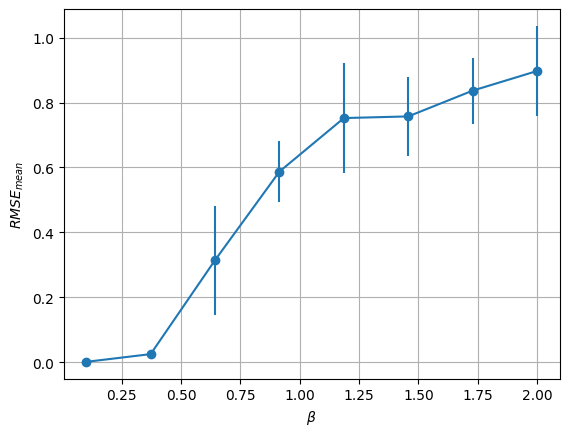

In [64]:
fig_RMSE, ax_RMSE = plt.subplots()

ax_RMSE.errorbar(betas, 
             np.mean(RMSE_mean_mf, axis=0),
             yerr=np.std(RMSE_mean_mf, axis=0),
             fmt='o-')
ax_RMSE.grid(True)
ax_RMSE.set_xlabel(r'$\beta$')
ax_RMSE.set_ylabel(r'$RMSE_{mean}$')

In [12]:
def get_couplings(n_trials, stds, n_spins):
    weights_per_condition = np.zeros((n_trials, len(stds), n_spins, n_spins))
    # Fill the array with normally distributed random numbers
    for i in range(n_trials):
        for j, std in enumerate(stds):
            weights_per_condition[i, j] = np.random.normal(0, stds, (n_spins, n_spins))
    return weights_per_condition
        
            


In [21]:
np.ones((100, 10, 5, 5)).transpose(1, 0, 2, 3).shape

(10, 100, 5, 5)

In [308]:
def check_phase_transition():

    n_spins = 15
    n_betas = 10
    J0 = 0
    J = 0.5
    J_field = 0.1
    n_trials = 10

    couplings = get_couplings(J0, J, n_spins) # shape=(combination, spi
    Ts  = np.linspace(0.5, 5, 15)
    field = np.random.randn(n_spins) * J_field 
    for row, T in enumerate(Ts):
        # Get all random states
        spin_states = np.array(list(itertools.product([-1 ,1], repeat=n_spins)))
        spin_energies = H(spin_states, couplings, field)
        spin_energies = np.exp(-1/T * spin_energies)

        exact(n_spins, couplings, field, 1/T)


check_phase_transition

<function __main__.check_phase_transition()>

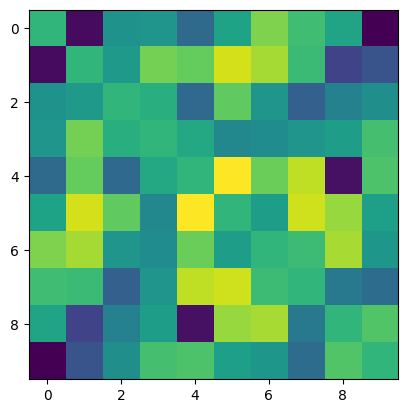

In [301]:
plt.imshow(get_couplings(J0=0, J=1, n=10))

In [34]:

# mean_RMSEcorr_for_beta_mf = np.mean(RMSE_corr_mf, axis=1)
# std_RMSEcorr_for_beta_mf = np.std(RMSE_corr_mf, axis=1)
# iterations_across_beta_mf = np.mean(iterations_mf, axis=1)

# fig_im, axes_im = plt.subplots(1, 2)
# axes_im[0].imshow(RMSE_mean_mf)
# axes_im[0].set_xlabel('trials')
# axes_im[0].set_ylabel('betas')
# axes_im[0].set_title(r'$RMS_{mean}$ per condition')
# axes_im[1].imshow(RMSE_corr_mf)
# axes_im[1].set_xlabel('trials')
# axes_im[1].set_ylabel('betas')
# axes_im[1].set_title(r'$RMS_{correlation}$ per condition')
# fig_im.tight_layout()

# fig, ax = plt.subplots(2, 1, sharex=True)
# fig.suptitle("Change of mean and correlation for for differrenet beta")
# ax[0].errorbar(betas, mean_RMSEmean_for_beta_mf, yerr=std_RMSEmean_for_beta_mf, fmt='o')
# ax[0].grid(True)
# ax[0].set_xlabel(r'$\beta$')
# ax[0].set_ylabel(r'$RMS_{mean}$')

# ax[1].errorbar(betas, mean_RMSEcorr_for_beta_mf, yerr=std_RMSEcorr_for_beta_mf, fmt='o')
# ax[1].grid(True)
# ax[1].set_xlabel(r'$\beta$')
# ax[1].set_ylabel(r'$RMS_{correlation}$')
# fig.tight_layout()

# fig_iter, ax_iter = plt.subplots()
# ax_iter.plot(betas, iterations_across_beta_mf)



NameError: name 'RMSE_mean_mf' is not defined